In [35]:
import pandas as pd
import sweetviz as sv
from pycaret.classification import *
import featuretools as ft
from sympy import sympify


def read_dataset():
    data = pd.read_csv('../data/output_set7.csv', sep=',')
    labels = pd.DataFrame()
    records = data["ViolatedRule"].str.split(",", expand = True)
    for i in range(records.shape[1]):
        
        labels[f"ViolatedRule{i}"] = records[i]
        print(labels[f"ViolatedRule{i}"].unique())
        labels.loc[labels[f"ViolatedRule{i}"] != "-1", f"ViolatedRule{i}"] = 1
        labels.loc[labels[f"ViolatedRule{i}"] == "-1", f"ViolatedRule{i}"] = 0


    return data, labels


def eda(data):
    # skip=["proline", "magnesium"],
    config = sv.FeatureConfig(force_num=['ViolatedRule'])
    my_report = sv.analyze(data, feat_cfg=config, target_feat='ViolatedRule')
    my_report.show_html()
    # profile = ProfileReport(data, title="Pandas Profiling Report")
    # profile.to_file(output_file=pathlib.Path("./data_report.html"))
    # profile.to_widgets()


def stack():
    top3 = compare_models(n_select=3)
    tuned_top3 = [tune_model(i) for i in top3]
    blender = blend_models(tuned_top3)
    stacker = stack_models(tuned_top3)
    best_auc_model = automl(optimize='AUC')
    print(best_auc_model)


def multi_level_feature_creation(X, trans_primitives_per_level): 
    feature_matrix = X
    initial_columns = X.columns

    
    for i,trans_primitives in enumerate(trans_primitives_per_level):
        print("Level: ", i)
        
        print("Columns: ", feature_matrix.columns)
        print(trans_primitives)
    
        es = ft.EntitySet(id = 'dataset')
    
        dataframe_name = "data" + str(i)
    
        es = es.add_dataframe(
            dataframe_name=dataframe_name,
            dataframe=feature_matrix,
            index="index" + str(i)
        )        

        feature_matrix, feature_defs = ft.dfs(entityset = es, target_dataframe_name = dataframe_name, trans_primitives = trans_primitives)
        
        #Simplify
        print(feature_matrix.shape)
        feature_matrix = feature_matrix.rename(columns={
            c: str(sympify(c)) for c in feature_matrix.columns
        })
        
        # This is needed to reset ww data 
        feature_matrix = pd.DataFrame(feature_matrix.to_dict())

    feature_matrix.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
    return feature_matrix, feature_defs

def static_features(features):
    features['left_diff'] = abs(features['LeftSideFirst'] - features['LeftSideLast'])
    features['right_diff'] = abs(features['RightSideFirst'] - features['RightSideFirst'])
    features['left_dens'] = features['left_diff'] / features['Length']
    features['right_dens'] = features['right_diff'] / features['Length']

    return features


def clean_dataset(features):
    
    features['LeftSideFirst'] = features['LeftSideFirst'].apply(lambda value: ''.join(i for i in str(value) if i.isdigit()))
    features['LeftSideLast'] = features['LeftSideLast'].apply(lambda value: ''.join(i for i in str(value) if i.isdigit()))
    features['RightSideFirst'] = features['RightSideFirst'].apply(lambda value: ''.join(i for i in str(value) if i.isdigit()))
    features['RightSideLast'] = features['RightSideLast'].apply(lambda value: ''.join(i for i in str(value) if i.isdigit()))
    features = features.apply(lambda x: x.str.strip() if isinstance(x, str) else x).replace('', np.nan)
    types_dict = {}
    for column in features.columns.values:
        types_dict[column] = 'float'

    features = features.astype(types_dict)
    return features

def eval_model(features,labels, column):
    print(column)
    #print(labels[column].value_counts())
    dataset = pd.concat([features,labels[column]], axis=1)
    s = setup(dataset, target=column, silent=True, log_experiment=False, experiment_name='first_rule', fix_imbalance=True)
    # best = compare_models()
    # results = pull()
    # print(results.head())
    investigated = create_model('xgboost')

    #models()
    
    #deep_check(investigated)
    #, search_library = 'optuna', search_algorithm = 'tpe'
    tuned_investigated = tune_model(investigated, choose_better=True, n_iter = 10)
    tuned_investigated
    plot_model(tuned_investigated, plot='pr')
    plot_model(investigated, plot='feature')
    plot_model(investigated, plot='confusion_matrix')
    
    evaluate_model(tuned_investigated)
    predict_model(tuned_investigated)
    final_rf = finalize_model(tuned_investigated)

In [36]:
drop_columns=['txId', 'FeatureID', 'ViolatedRule', 'LeftSideIntermediate', 'RightSideIntermediate']
catgories_columns=['HouseNumberVariance', 'LeftSideInterpolation', 'RightSideInterpolation','fow']
features, labels = read_dataset()

features = features.drop(columns=drop_columns)
categories_features = features[catgories_columns]
features = features.drop(columns=catgories_columns)

features = clean_dataset(features)
features.info()
features


['-1' '50901']
['-1' '50890']
['-1' '50897']
['-1' '51516']
['-1' '50905']
['53021' '-1']
['-1' '50883']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7999 entries, 0 to 7998
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   LeftSideFirst   6115 non-null   float64
 1   LeftSideLast    6115 non-null   float64
 2   RightSideFirst  6234 non-null   float64
 3   RightSideLast   6234 non-null   float64
 4   Length          7999 non-null   float64
dtypes: float64(5)
memory usage: 312.6 KB


,LeftSideFirst,LeftSideLast,RightSideFirst,RightSideLast,Length
0,NaN,NaN,1.0,4341.0,12473.524269
1,2.0,2.0,NaN,NaN,5454.575052
2,5.0,5.0,12.0,12.0,10279.898141
3,8.0,8.0,36.0,25.0,5882.996800
4,3.0,3.0,NaN,NaN,22700.651155
...,...,...,...,...,...
7994,NaN,NaN,NaN,NaN,2515.591746
7995,315.0,399.0,314.0,398.0,1611.870032
7996,307.0,307.0,306.0,306.0,2346.607202
7997,405.0,499.0,404.0,27372.0,20659.509120


In [37]:
features_per_level = [['subtract_numeric', 'add_numeric'], 
                      ['absolute'], 
                      ['divide_numeric']] #         ['add_numeric', 'multiply_numeric', 'subtract_numeric', 'divide_numeric', 'multiply_numeric_scalar']
features, _ = multi_level_feature_creation(features, features_per_level)
#features = static_features(features)

features = pd.concat([features, categories_features], axis=1)
features
#features.to_csv('../data/output_6K_5R_HNR_set6_out.csv')
# eda(data)

# print(features.info())
# print(features.describe().transpose())

Level:  0
Columns:  Index(['LeftSideFirst', 'LeftSideLast', 'RightSideFirst', 'RightSideLast',
       'Length'],
      dtype='object')
['subtract_numeric', 'add_numeric']
(7999, 25)
Level:  1
Columns:  Index(['LeftSideFirst', 'LeftSideLast', 'RightSideFirst', 'RightSideLast',
       'Length', 'LeftSideFirst + LeftSideLast', 'LeftSideFirst + Length',
       'LeftSideFirst + RightSideFirst', 'LeftSideFirst + RightSideLast',
       'LeftSideLast + Length', 'LeftSideLast + RightSideFirst',
       'LeftSideLast + RightSideLast', 'Length + RightSideFirst',
       'Length + RightSideLast', 'RightSideFirst + RightSideLast',
       'LeftSideFirst - LeftSideLast', 'LeftSideFirst - Length',
       'LeftSideFirst - RightSideFirst', 'LeftSideFirst - RightSideLast',
       'LeftSideLast - Length', 'LeftSideLast - RightSideFirst',
       'LeftSideLast - RightSideLast', 'Length - RightSideFirst',
       'Length - RightSideLast', 'RightSideFirst - RightSideLast'],
      dtype='object')
['absolute']
(79

,LeftSideFirst,LeftSideLast,RightSideFirst,RightSideLast,Length,LeftSideFirst + LeftSideLast,LeftSideFirst + Length,LeftSideFirst + RightSideFirst,LeftSideFirst + RightSideLast,LeftSideLast + Length,...,RightSideLast + RightSideLast/Length,-RightSideFirst + RightSideLast/Length,-RightSideLast + RightSideLast/Length,RightSideLast/RightSideFirst,RightSideLast + RightSideLast/RightSideFirst,-RightSideLast + RightSideLast/RightSideFirst,HouseNumberVariance,LeftSideInterpolation,RightSideInterpolation,fow
0,0,0,1,4341,12473.524269,0,0.000000,0,0,0.000000,...,0.258170,0.348045,0.533783,4341.000000,0.999770,-1.000230,Odd,NaN,NotInterpolated,SingleCarriageway
1,2,2,0,0,5454.575052,4,5456.575052,0,0,5456.575052,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Irregular,NotInterpolated,NaN,SingleCarriageway
2,5,5,12,12,10279.898141,10,10284.898141,17,17,10284.898141,...,0.001166,0.001169,0.001169,1.000000,0.500000,0.000000,Even,NotInterpolated,NotInterpolated,SingleCarriageway
3,8,8,36,25,5882.996800,16,5890.996800,44,33,5890.996800,...,0.004232,0.004276,0.004268,0.694444,0.409836,2.272727,NumericMixed,NotInterpolated,NotInterpolated,SingleCarriageway
4,3,3,0,0,22700.651155,6,22703.651155,0,0,22703.651155,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Odd,NotInterpolated,NaN,Walkway
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7994,0,0,0,0,2515.591746,0,0.000000,0,0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,SingleCarriageway
7995,315,399,314,398,1611.870032,714,1926.870032,629,713,2010.870032,...,0.198023,0.306656,0.327877,1.267516,0.558989,-4.738095,Even,NotInterpolated,NotInterpolated,SingleCarriageway
7996,307,307,306,306,2346.607202,614,2653.607202,613,613,2653.607202,...,0.115358,0.149955,0.149955,1.000000,0.500000,0.000000,Even,NotInterpolated,NotInterpolated,SingleCarriageway
7997,405,499,404,27372,20659.509120,904,21064.509120,809,27777,21158.509120,...,0.569876,1.351336,-4.077771,67.752475,0.985455,-1.014981,Even,NotInterpolated,NotInterpolated,SingleCarriageway


In [38]:
for index, column in enumerate(labels.columns.values):
    zeros = labels[labels[f"ViolatedRule{index}"] == 0].shape[0]
    ones = labels[labels[f"ViolatedRule{index}"] == 1].shape[0]
    print(f'{zeros}, {ones} {zeros + ones}') 



7340, 659 7999
7774, 225 7999
7802, 197 7999
7747, 252 7999
7965, 34 7999
7433, 566 7999
7393, 606 7999


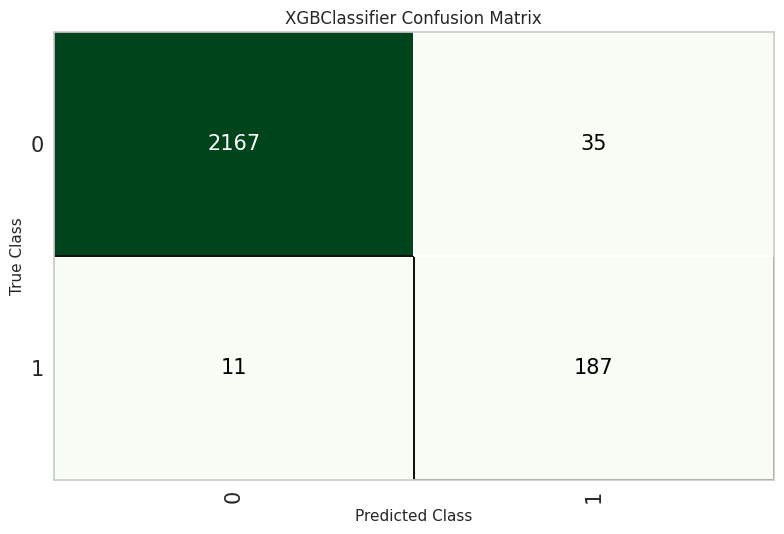

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9808,0.9972,0.9444,0.8423,0.8905,0.8800,0.8817


In [39]:
# models generator per Rule
# because results are overwritten index == 0 
for index, column in enumerate(labels.columns.values):
    if column.startswith('ViolatedRule') and index==0:
        eval_model(features,labels,column)

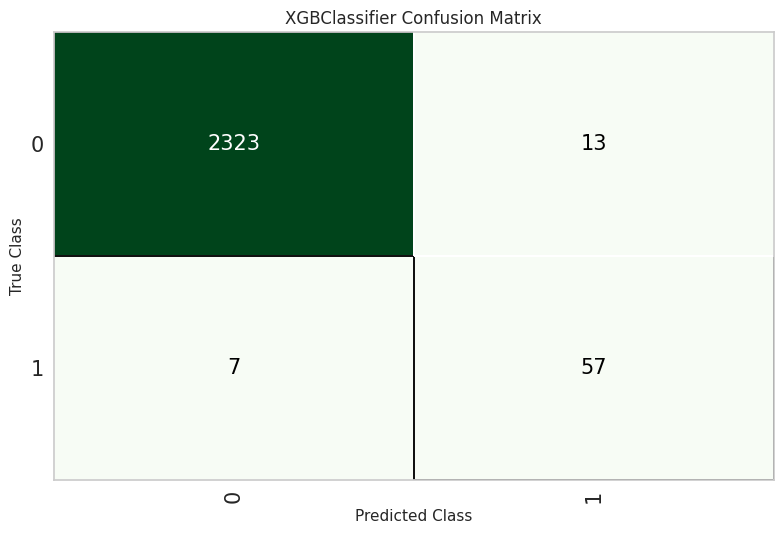

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9917,0.9844,0.8906,0.8143,0.8507,0.8465,0.8474


In [40]:
eval_model(features,labels,'ViolatedRule1')

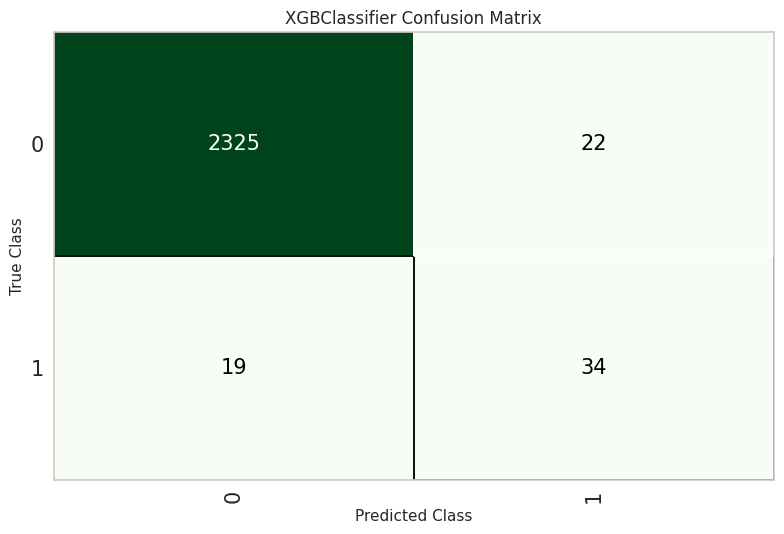

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9829,0.9852,0.6415,0.6071,0.6239,0.6151,0.6154


In [41]:
eval_model(features,labels,'ViolatedRule2')

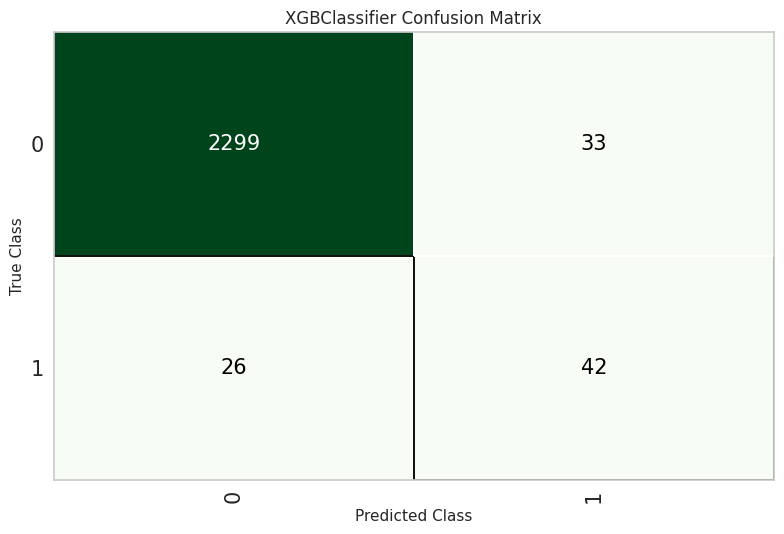

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9754,0.9664,0.6176,0.5600,0.5874,0.5748,0.5755


In [42]:
eval_model(features,labels,'ViolatedRule3')

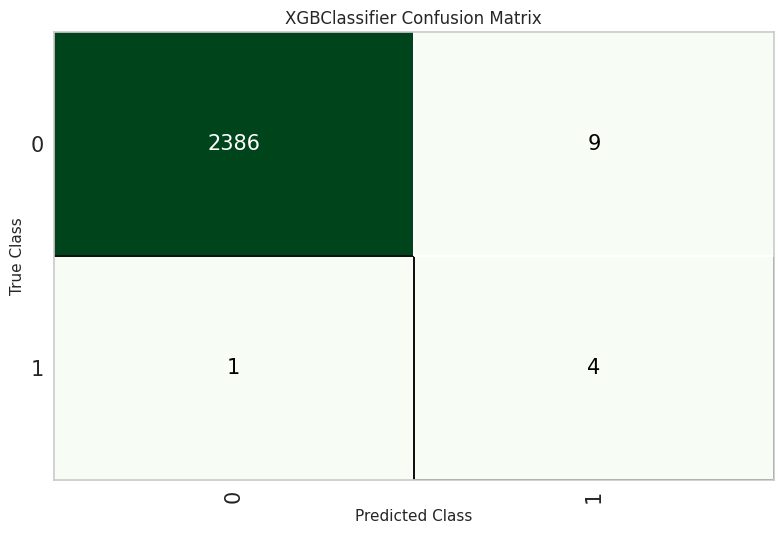

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9958,0.9953,0.8000,0.3077,0.4444,0.4428,0.4946


/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [43]:
eval_model(features,labels,'ViolatedRule4')

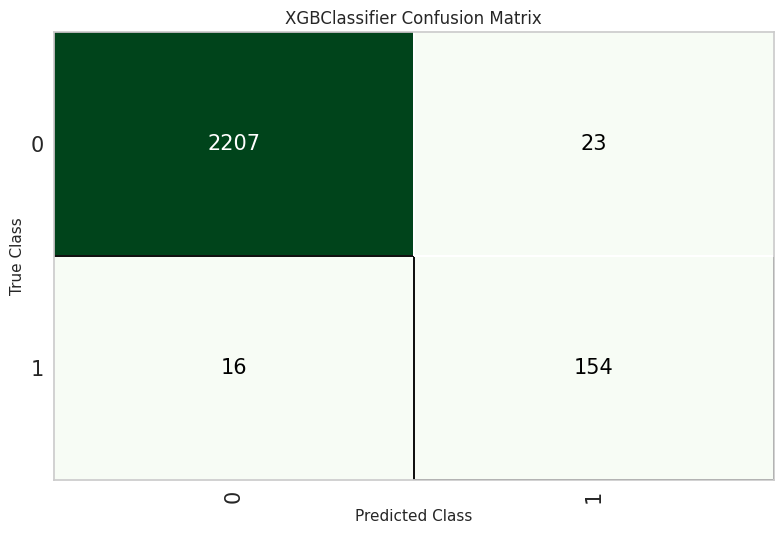

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9838,0.9968,0.9059,0.8701,0.8876,0.8789,0.8791


In [44]:
eval_model(features,labels,'ViolatedRule5')

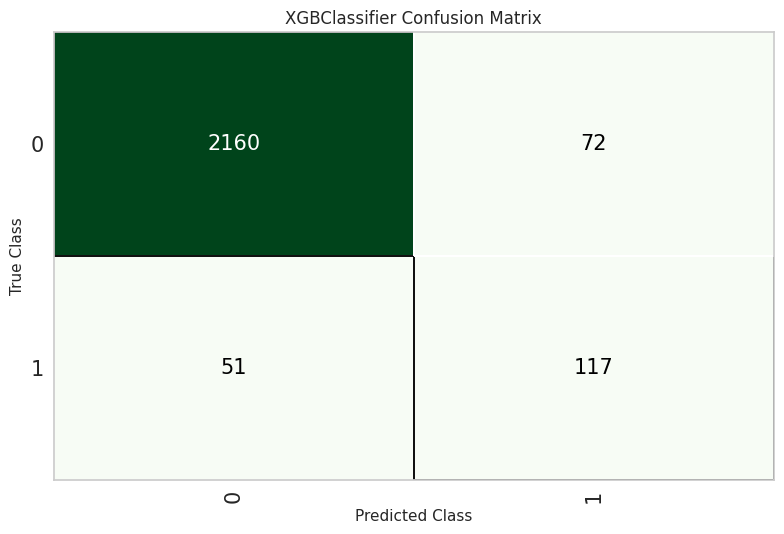

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9488,0.9574,0.6964,0.6190,0.6555,0.6279,0.6292


In [45]:
eval_model(features,labels,'ViolatedRule6')